In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

# Tutorial - Using fastai on a custom new task

> How to use the mid-level API for data collection, model creation and training

In [ ]:
#all_slow

In this tutorial, we will see how to deal with a new type of task using the middle layer of the fastai library. The example we will use is a Siamese network, that takes two images and determine if they are of the same class or not. In particular we will see:

- how to quickly get `DataLoaders` from a standard PyTorch `Datasets`
- how to adapt this in a `Transform` to get some of the show features of fastai
- how to add some new behavior to `show_batch`/`show_results` for a custom task
- how to write a custom `DataBlock`
- how to create your own model from a pretrained model
- how to pass along a custom `splitter` to `Learner` to take advantage of transfer learning

## Preparing the data

To make our data ready for training a model, we need to create a `DataLoaders` object in fastai. It is just a wrapper around a training `DataLoader` and a validation `DataLoader`, so if you already have your own PyTorch dataloaders, you can create such an object directly.

Here we don't have anything ready yet. Usually, when using PyTorch, the first step is to create a `Dataset` that is then wrapped inside a `DataLoader`. We will do this first, then see how to change this `Dataset` into a `Transform` that will let us take advantage of fastai's functionality for showing a batch or using data augmentation on the GPU. Lastly we will see how we can customize the data block API and create our own new `TransformBlock`.

### Purely in PyTorch

To begin with, we will only use PyTorch and PIL to create a `Dataset` and see how to get this inside fastai. The only helper functions from fastai we will use are `untar_data` (to download and untar the dataset) and `get_image_files` (that looks for all images in a folder recursively). Here, we will use the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

In [ ]:
from fastai.data.external import untar_data,URLs
from fastai.data.transforms import get_image_files

`untar_data` returns a `pathlib.Path` object with the location of the decompressed dataset, and in this case, all the images are in an images subfolder:

In [ ]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")
files[0]

Path('/home/yijin/.fastai/data/oxford-iiit-pet/images/great_pyrenees_97.jpg')

We can open the first image with PIL and have a look at it:

In [ ]:
import PIL

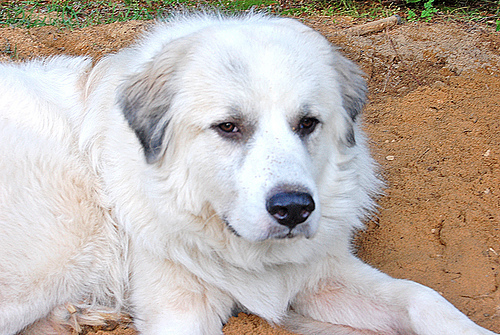

In [ ]:
img = PIL.Image.open(files[0])
img

Let's wrap all the standard preprocessing (resize, conversion to tensor, dividing by 255 and reordering of the channels) in one helper function:

In [ ]:
import torch
import numpy as np

In [ ]:
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

In [ ]:
open_image(files[0]).shape

torch.Size([3, 224, 224])

We can see the label of our image is in the filename, before the last `_` and some number. We can then use a regex expression to create a label function:

In [ ]:
import re

In [ ]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

label_func(files[0])

'great_pyrenees'

Now lets gather all unique labels:

In [ ]:
labels = list(set(files.map(label_func)))
len(labels)

37

So we have 37 different breeds of pets. To create our Siamese datasets, we will need to create tuple of images for inputs and the target will be `True` if the images are of the same class, `False` otherwise. It will be useful to have a mapping from class to list of filenames of that class, to quickly pick a random image for any class.

In [ ]:
lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}

Now we are ready to create our datasets. For the training set, we will go through all our training filenames for the first image, then pick randomly:

- a filename of the same class for the second image (with probability 0.5)
- a filename of a different class for the second image (with probability 0.5)

We will go through that random draw each time we access an item, to have as many samples as possible. For the validation set however, we will fix that random draw once and for all (otherwise we will validate on a different dataset at each epoch).

In [ ]:
import random

In [ ]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
        
    def __getitem__(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (img1, img2, torch.Tensor([same]).squeeze())
    
    def __len__(self): return len(self.files)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(lbl2files[cls]),same

We just need to split our filenames between a training and validation set to use it.

In [ ]:
idxs = np.random.permutation(range(len(files)))
cut = int(0.8 * len(files))
train_files = files[idxs[:cut]]
valid_files = files[idxs[cut:]]

We can then use it to create datasets.

In [ ]:
train_ds = SiameseDataset(train_files)
valid_ds = SiameseDataset(valid_files, is_valid=True)

All of the above would be different for your custom problem, the main point is that as soon as you have some `Dataset`s, you can create a fastai's `DataLoaders` with the following factory method:

In [ ]:
from fastai.data.core import DataLoaders

In [ ]:
dls = DataLoaders.from_dsets(train_ds, valid_ds)

You can then use this `DataLoaders` object in a `Learner` and start training. Most methods that don't rely on showing something (e.g. `DataLoaders.show_batch` and `Learner.show_results` for instance) should work. For instance, you can get and inspect a batch with:

In [ ]:
b = dls.one_batch()

If you want to use the GPU, you can just write:

In [ ]:
dls = dls.cuda()

Now, what is a bit annoying is that we have to rewrite everything that is already in fastai if we want to normalize our images, or apply data augmentation. With minimal changes to the code we wrote, we can still access all of that and get all the show method to work as a cherry on the top. Let's see how.

### Using the mid-level API

When you have a custom dataset like before, you can easily convert it into a fastai `Transform` by just changing the `__getitem__` function to <code>encodes</code>. In general, a `Transform` in fastai calls the <code>encodes</code> method when you apply it on an item (a bit like PyTorch modules call `forward` when applied on something) so this will transform your python dataset in a function that transforms integer to your data.

If you then return a tuple (or a subclass of a tuple), and use fastai's semantic type, you can then apply any other fastai's transform on your data and it will be dispatched properly. Let's see how that works:

In [ ]:
from fastai.vision.all import *

In [ ]:
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
        
    def encodes(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (TensorImage(img1), TensorImage(img2), torch.Tensor([same]).squeeze())
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(lbl2files[cls]),same

So three things changed:

- the `__len__` disappeared, we won't need it 
- `__getitem___` became <code>encodes</code>
- we return `TensorImage` for our images

How do we build a dataset with this? We will use `TfmdLists`. It's just an object that lazily applies a collection of `Transform`s on a list. Here since our transform takes integers, we will pass simple ranges for this list.

In [ ]:
train_tl= TfmdLists(range(len(train_files)), SiameseTransform(train_files))
valid_tl= TfmdLists(range(len(valid_files)), SiameseTransform(valid_files, is_valid=True))

Then, when we create a `DataLoader`, we can add any transform we like. fastai replaces the PyTorch `DataLoader` with its own version that has more hooks (but is fully compatible with PyTorch). The transforms we would like to be applied to items should be passed to `after_item`, the one we would like to be applied on a batch of data should be passed to `after_batch`.

In [ ]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, 
                             after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
dls = dls.cuda()

So with little change, we can use fastai normalization and data augmentation. If we are ready to do a bit more additional coding, we can even get the show behavior to work properly.

### Making show work

The show methods in fastai all rely on some types being able to show themselves. Additionally, some transforms that need to be reversed for showing purposes (like changing a category to an index, or normalizing) have a <code>decodes</code> method to undo what their encodes did. In general, fastai will call those decodes method until it arrives at a type that knows how to show itself, then call the show method on this type.

So to make this work, let's first create a new type with a show method!

In [ ]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

There is bit of code in the first part of the test that you can ignore, it's mostly to make the show method work on PIL Image as well as tensors. The main stuff happens in the last two lines: we create a black line of 10 pixels and show the tensor with our two images concatenated, with the black line in the middle. In general, `ctx` represents the object where we will show our thing. In this case, it could be a given matplotlib axis.

Let's see an example:

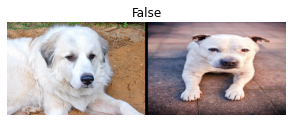

In [ ]:
img = PILImage.create(files[0])
img1 = PILImage.create(files[1])
s = SiameseImage(img, img1, False)
s.show();

Note that we used the fastai type `PILImage` instead of a PIL.Image. That is to get access to fastai's transforms. For instance, we can use `Resize` and `ToTensor` directly on our `SiamesImage`. Since it subclasses tuple, those transforms are dispatched and applied to the part that make sense (the `PILImage`s, not the bool).

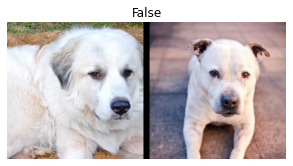

In [ ]:
tst = Resize(224)(s)
tst = ToTensor()(tst)
tst.show();

Now let's rewrite a bit our previous transform. Instead of taking integers, we can take files directly for instance. Also, in fastai, splits are usually handled by helper functions that return two lists of integers (the ones in the training set and the ones in the validation set), so let's adapt a bit the code from before to have the validation images drawn once and for all. We also need to add in the mapping dictionaries from class to list of filenames of that class, separately for the train and valid splits, so that there is total separation between the training and validation sets, i.e. 'train' files should only draw samples from train split; 'valid' from valid split.

In [ ]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [{l: [f for f in files[splits[i]] if label_func(f) == l] for l in labels}
                          for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f,0))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, same)
    
    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(self.splbl2files[split][cls]),same

Then we create our splits using a `RandomSplitter`:

In [ ]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)

And we test that tfm.valid does not contain items from the train split:

In [ ]:
valids = [v[0] for k,v in tfm.valid.items()]      
assert not [v for v in valids if v in files[splits[0]]]

And we can pass those splits to `TfmdLists`, which will then create the validation and the training set for us.

In [ ]:
tls = TfmdLists(files, tfm, splits=splits)

We can now use methods like `show_at`:

<AxesSubplot:title={'center':'False'}>

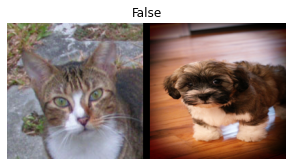

In [ ]:
show_at(tls.valid, 0)

And we can create a `DataLoaders` like before, by adding our custom transforms for `after_item` and `after_batch`.

In [ ]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

If we try just now, `show_batch` will not quite work: the default behavior relies on some data build using data blocks, and we used one big transform for everything. In consequence, instead of having an input with a certain type and an output of a certain type, we have one big type for the whole data. If we look at a batch, we can see that the fastai library has propagated that type for us through every transform and batching operation:

In [ ]:
b = dls.one_batch()
type(b)

__main__.SiameseImage

When we call `show_batch`, the fastai library will realize the batch as a whole has a show method, so it must know how to show itself. It will send that batch directly to the type-dispatched function `show_batch`. The signature of this function is the following:
```python 
show_batch(x, y, samples, ctxs=None, **kwargs)
```
where the kwargs are specific to the application (here we will have `nrows`, `ncols` and `figsize` for instance). In our case, the batch will be sent as a whole to `x` and `y` and `samples` will be `None` (those arguments are used when the batch does not have a type that knows how to show itself, see the next section).

To write our custom `show_batch` we just need to use the type annotation on `x` like this:

In [ ]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

We will see in the next section that the behavior is different when we have a batch that does not have a show method (which is the case most of the time, only the input and target of the batch have those show methods). In that case, the arguments `y` and `samples` are useful. Here, everything is in `x`, because since the batch knows how to show itself as a whole, it is sent as a whole.

Here, we create a list of matplotlib axis with the utility function `get_grid` then pass it along to all `SiameseImage.show`. Let's see how this looks in practice:

In [ ]:
b = dls.one_batch()

In [ ]:
dls._types

{__main__.SiameseImage: [fastai.torch_core.TensorImage,
  fastai.torch_core.TensorImage,
  torch.Tensor]}

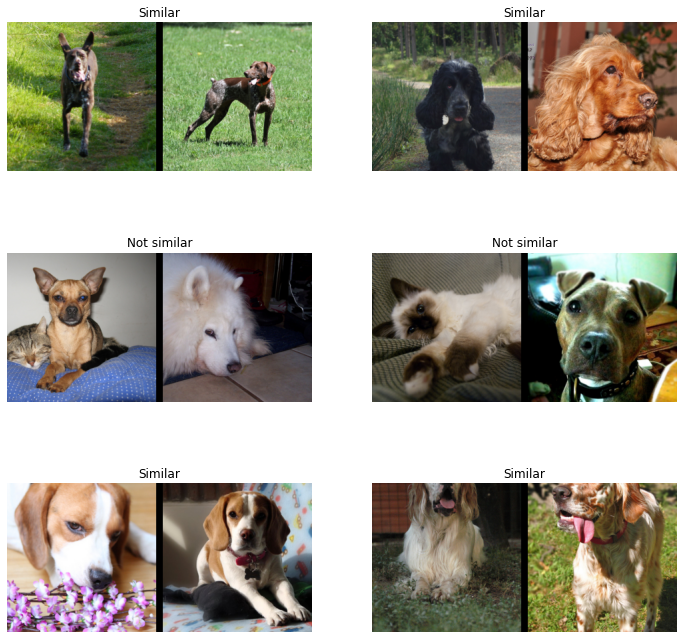

In [ ]:
dls.show_batch()

And we will see in the training section it's as easy to make a custom `show_results`. Now let's see how we could have written our own data block.

### Writing your custom data block

The siamese problem is just a particular case of problem with our inputs being a tuple of images and our target being a category. If the type "tuple of images" comes again in other problems with a different target, it might be useful to create a custom block for it, to be able to leverage the power of the data block API.

**NB:** if your problem only has one particular setup and you don't need the modular aspect for various targets, what we did before is perfectly fine and you should look no further.

Let's create a type to represent our tuple of two images:

In [ ]:
class ImageTuple(fastuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

Since it's a subclass of `fastuple`, `Transform`s will be applied over each part of the tuple. For instance `ToTensor` will convert this `ImageTuple` to a tuple of `TensorImage`s:

In [ ]:
img = ImageTuple.create((files[0], files[1]))
tst = ToTensor()(img)
type(tst[0]),type(tst[1])

(fastai.torch_core.TensorImage, fastai.torch_core.TensorImage)

In the show method, we did not bother with non-tensor elements this time (we could copy and paste the same code as before). Showing assumes we have a resize transform and that we convert the images to tensors in our procesing pipeline:

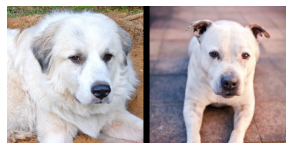

In [ ]:
img1 = Resize(224)(img)
tst = ToTensor()(img1)
tst.show();

We can now define a block associated to `ImageTuple` that we will use in the data block API. A block is basically a set of default transforms, here we specify how to create the `ImageTuple` and the `IntToFloatTensor` transform necessary for image preprocessing:

In [ ]:
def ImageTupleBlock(): return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

To gather our data with the data block API we will use the following functions:

In [ ]:
splits_files = [files[splits[i]] for i in range(2)]
splits_sets = mapped(set, splits_files)

In [ ]:
def get_split(f):
    for i,s in enumerate(splits_sets):
        if f in s: return i
    raise ValueError(f'File {f} is not presented in any split.')

In [ ]:
splbl2files = [{l: [f for f in s if label_func(f) == l] for l in labels} for s in splits_sets]

In [ ]:
def splitter(items): 
    def get_split_files(i): return [j for j,(f1,f2,same) in enumerate(items) if get_split(f1)==i]
    return get_split_files(0),get_split_files(1)

In [ ]:
def draw_other(f):
    same = random.random() < 0.5
    cls = label_func(f)
    split = get_split(f)
    if not same: cls = random.choice(L(l for l in labels if l != cls)) 
    return random.choice(splbl2files[split][cls]),same

In [ ]:
def get_tuples(files): return [[f, *draw_other(f)] for f in files]

And we are ready to define our block:

In [ ]:
def get_x(t): return t[:2]
def get_y(t): return t[2]

In [ ]:
siamese = DataBlock(
    blocks=(ImageTupleBlock, CategoryBlock),
    get_items=get_tuples,
    get_x=get_x, get_y=get_y,
    splitter=splitter,
    item_tfms=Resize(224),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
dls = siamese.dataloaders(files)

We can check the types of the elements in one batch with the `explode_types` method. Here we have a tuple with one `ImageTuple` of two `TensorImage`s and one `TensorCategory`. The transform properly kept the types of everything even after collating the samples together!

In [ ]:
b = dls.one_batch()
explode_types(b)

{tuple: [{__main__.ImageTuple: [fastai.torch_core.TensorImage,
    fastai.torch_core.TensorImage]},
  fastai.torch_core.TensorCategory]}

The `show_batch` method here works out of the box, but to customize how things are organized, we can define a dispatched `show_batch` function. Here the whole batch is just a tuple, so doesn't have a show method. The fastai library will dispatch on the first part of the tuple (x) and second part of the tuple (y), the actual samples being in the `samples` variable.

Here we only dispatch on the `x` (which means this method will be used for `x`s that are `ImageTuple` and any `y`s), but we could have custom behaviors depending on the targets.

In [ ]:
@typedispatch
def show_batch(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

As a sidenote, `x`and `y` are not actually used (all that needs to be shown is in the `samples` list). They are only passed along for type-dispatching because they carry the types of our inputs and targets.

We can now have a look:

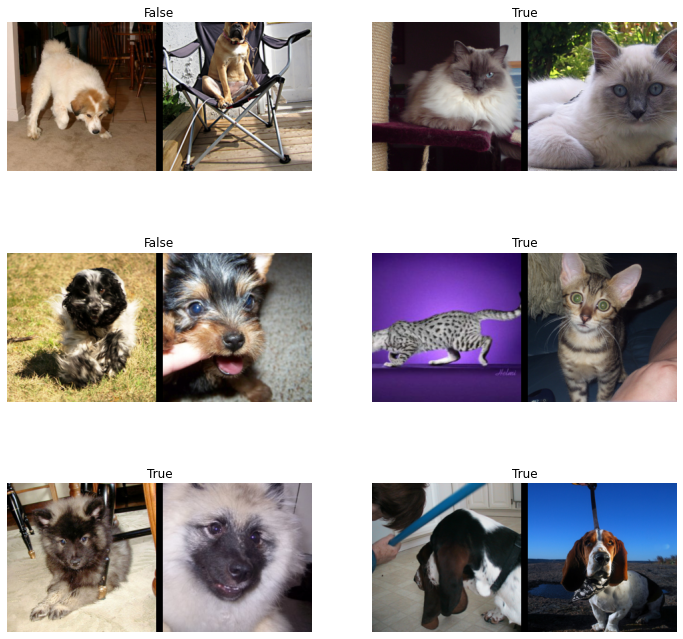

In [ ]:
dls.show_batch()

## Training a model

### The model

We are now at the stage where we can train a model on this data. We will use a very simple approach: take the body of a pretrained model and make the two images pass through it. Then build a head the usual way, with just twice as many features. The model in itself can be written like this:

In [ ]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

For our encoder, we use the fastai function `create_body`. It takes an architecture and an index where to cut it. By default it will use the pretrained version of the model we pick. If we want to check where fastai usually cuts the model, we can have a look at the `model_meta` dictionary:

In [ ]:
model_meta[resnet34]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

So we need to cut at -2:

In [ ]:
encoder = create_body(resnet34, cut=-2)

Let's have a look at the last block of this encoder:

In [ ]:
encoder[-1]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

It ends up with 512 features, so for our custom head, we will need to multiply this by 4 (i.e. 2*2): 2 because we have two images concatenated, and another 2 because of the fastai concat-pool trick (we concatenate the average pool and the max pool of the features). The `create_head` function will give us the head that is usually used in fastai's transfer learning models.

We also need to define the number of outputs of our head `n_out`, in our case it's 2: One for predicting both images are from the same class, and the other, to predict the contrary.

In [ ]:
head = create_head(512*4, 2, ps=0.5)
model = SiameseModel(encoder, head)

Let's have a look at the generated head:

In [ ]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

### Train the model

We are almost ready to train our model. The last piece missing is a custom splitter: in order to use transfer learning efficiently, we will want to freeze the pretrained model at first, and train only the head. A splitter is a function that takes a model and returns lists of parameters. The `params` function is useful to return all parameters of the model, so we can create a simple splitter like so:

In [ ]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

Then we use the traditional `CrossEntropyLossFlat` loss function from fastai (the same as `nn.CrossEntropyLoss`, but flattened). The only thing is, if using the data built by the mid-level API, we have a tensor of bools for our targets, so we need to convert it to integers otherwise PyTorch will throw an error.

In [ ]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

Let's grab the data as built by the mid-level API:

In [ ]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [{l: [f for f in files[splits[i]] if label_func(f) == l] for l in labels}
                          for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f,0))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, int(same))
    
    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(self.splbl2files[split][cls]),same

In [ ]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

Again, test that tfm.valid does not contain items from the train split:

In [ ]:
valids = [v[0] for k,v in tfm.valid.items()]      
assert not [v for v in valids if v in files[splits[0]]]

We can then create our `Learner`:

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=accuracy)

Since we are not using a convenience function that directly creates the `Learner` for us, we need to `freeze` it manually:

In [ ]:
learn.freeze()

Then we can use the learning rate finder:

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.013182567432522774)

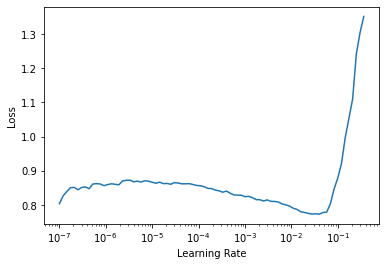

In [ ]:
learn.lr_find()

Train for a bit the head:

In [ ]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.549957,0.384771,0.835589,01:27
1,0.398177,0.269522,0.901218,01:26
2,0.301933,0.204902,0.919486,01:26
3,0.243943,0.195547,0.922869,01:26


Unfreeze and train the full model for a little more:

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.235589,0.186482,0.927605,02:03
1,0.235912,0.182467,0.931664,02:02
2,0.222281,0.183151,0.928281,02:02
3,0.213780,0.186204,0.927605,02:02


### Making show_results work

In [ ]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

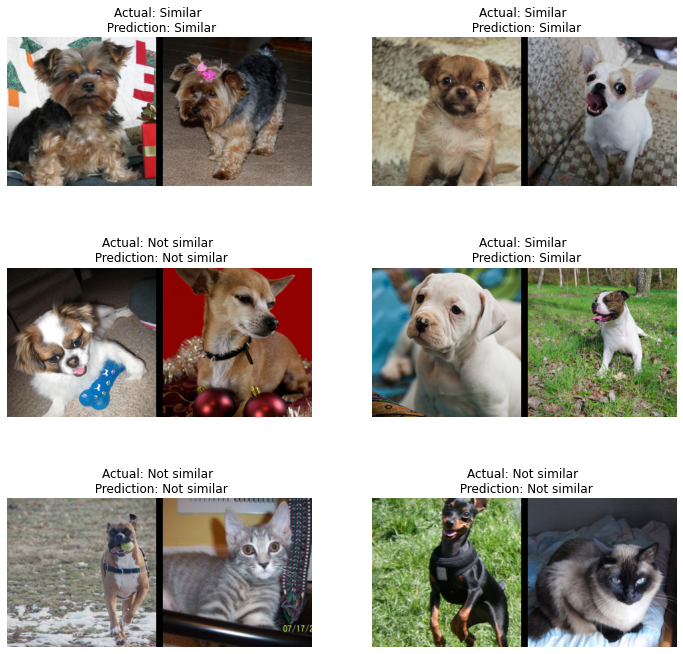

In [ ]:
learn.show_results()

### Patch in a `siampredict` method to `Learner`, to automatically show images and prediction

In [ ]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    if res[0] == tensor(0):
        SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
    else:
        SiameseImage(item[0], item[1], 'Prediction: Similar').show()
    return res

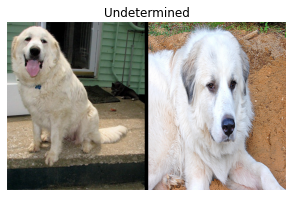

In [ ]:
imgtest = PILImage.create(files[0])
imgval = PILImage.create(files[100])
siamtest = SiameseImage(imgval, imgtest)
siamtest.show();

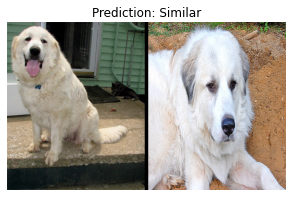

In [ ]:
res = learn.siampredict(siamtest)